In [9]:
from glob import glob
import baltic as bt
from collections import defaultdict
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import pickle
%matplotlib inline
import random
from pprint import pprint

In [16]:
treefiles = glob('../../recombination/segment_ML_trees/RAxML_bestTree*')
treefiles.sort(key=lambda x: int(x.split('_')[-2]))

def make_bt_tree(treefile):
    t = bt.tree()
    bt.make_tree(open(treefile, 'r').readlines()[0].strip(), t)
    t.treeStats() ## initial traversal, checks for stats
    t.sortBranches() ## traverses tree, sorts branches, draws tree
    return t

trees = { i:make_bt_tree(treefile) for i,treefile in enumerate(treefiles)}


Tree height: 4.249024
Tree length: 27.026251

Tree is strictly bifurcating = False

Tree is multitype = False

Tree has annotations = False

Numbers of objects in tree: 124 (61 nodes and 63 leaves)


Tree height: 2.048321
Tree length: 18.349830

Tree is strictly bifurcating = False

Tree is multitype = False

Tree has annotations = False

Numbers of objects in tree: 126 (62 nodes and 64 leaves)


Tree height: 3.055324
Tree length: 26.519082

Tree is strictly bifurcating = False

Tree is multitype = False

Tree has annotations = False

Numbers of objects in tree: 126 (62 nodes and 64 leaves)


Tree height: 1.405686
Tree length: 17.804388

Tree is strictly bifurcating = False

Tree is multitype = False

Tree has annotations = False

Numbers of objects in tree: 126 (62 nodes and 64 leaves)


Tree height: 1.805918
Tree length: 18.138851

Tree is strictly bifurcating = False

Tree is multitype = False

Tree has annotations = False

Numbers of objects in tree: 126 (62 nodes and 64 leaves)



In [17]:
def euclidean((x1,y1),(x2,y2)):
    return ((float(x2)-float(x1))**2+(float(y1)-float(y2))**2)**0.5

def sum_tip_distances(tree1,tree2):
    tree1_tips = { k.numName: k for k in tree1.Objects if k.branchType=='leaf' }
    tree2_tips = { k.numName: k for k in tree2.Objects if k.branchType=='leaf' }
    shared_tips = set(tree1_tips.keys()).intersection(set(tree2_tips.keys()))
    total_dist = 0.0
    
    for t in shared_tips:
        total_dist += euclidean( (tree1_tips[t].x, tree1_tips[t].y), (tree2_tips[t].x, tree2_tips[t].y) )
    
    return total_dist

def untangle(tree1, tree2):
    current_distance = sum_tip_distances(tree1, tree2)
    
    for n in sorted(tree2.nodes,key=lambda x: -x.height):
        if n.parent=='Root':
            continue
        n.rotate()
        tree2.drawTree()
        new_distance = sum_tip_distances(tree1, tree2)
        if new_distance <= current_distance:
            current_distance = new_distance
            continue
        else:
            n.rotate()
            tree2.drawTree()
            
for i in range(1,len(trees)):
    untangle(trees[i-1], trees[i])

In [39]:
CDS = {'vpu': [6045, 6310, 2], 
       'tat_1': [5831,6045,2], 
       'tat_2': [8379,8469,3],
       "3' LTR": [9086, 9719, 2], 
       'vif': [5041, 5619, 3], 
       'vpr': [5559, 5850, 1], 
       'rev_1': [5970, 6045, 1], 
       'rev_2':[8379,8653,2],
       "5' LTR": [1, 634, 3], 
       'nef': [8797, 9417, 3], 
       'pol': [2085, 5096, 1], 
       'env': [6225, 8795, 1], 
       'gag': [790, 2292, 3]}

In [40]:
ntrees = len(trees.keys())
colors = pickle.load(open('../colors.p', 'rb'))

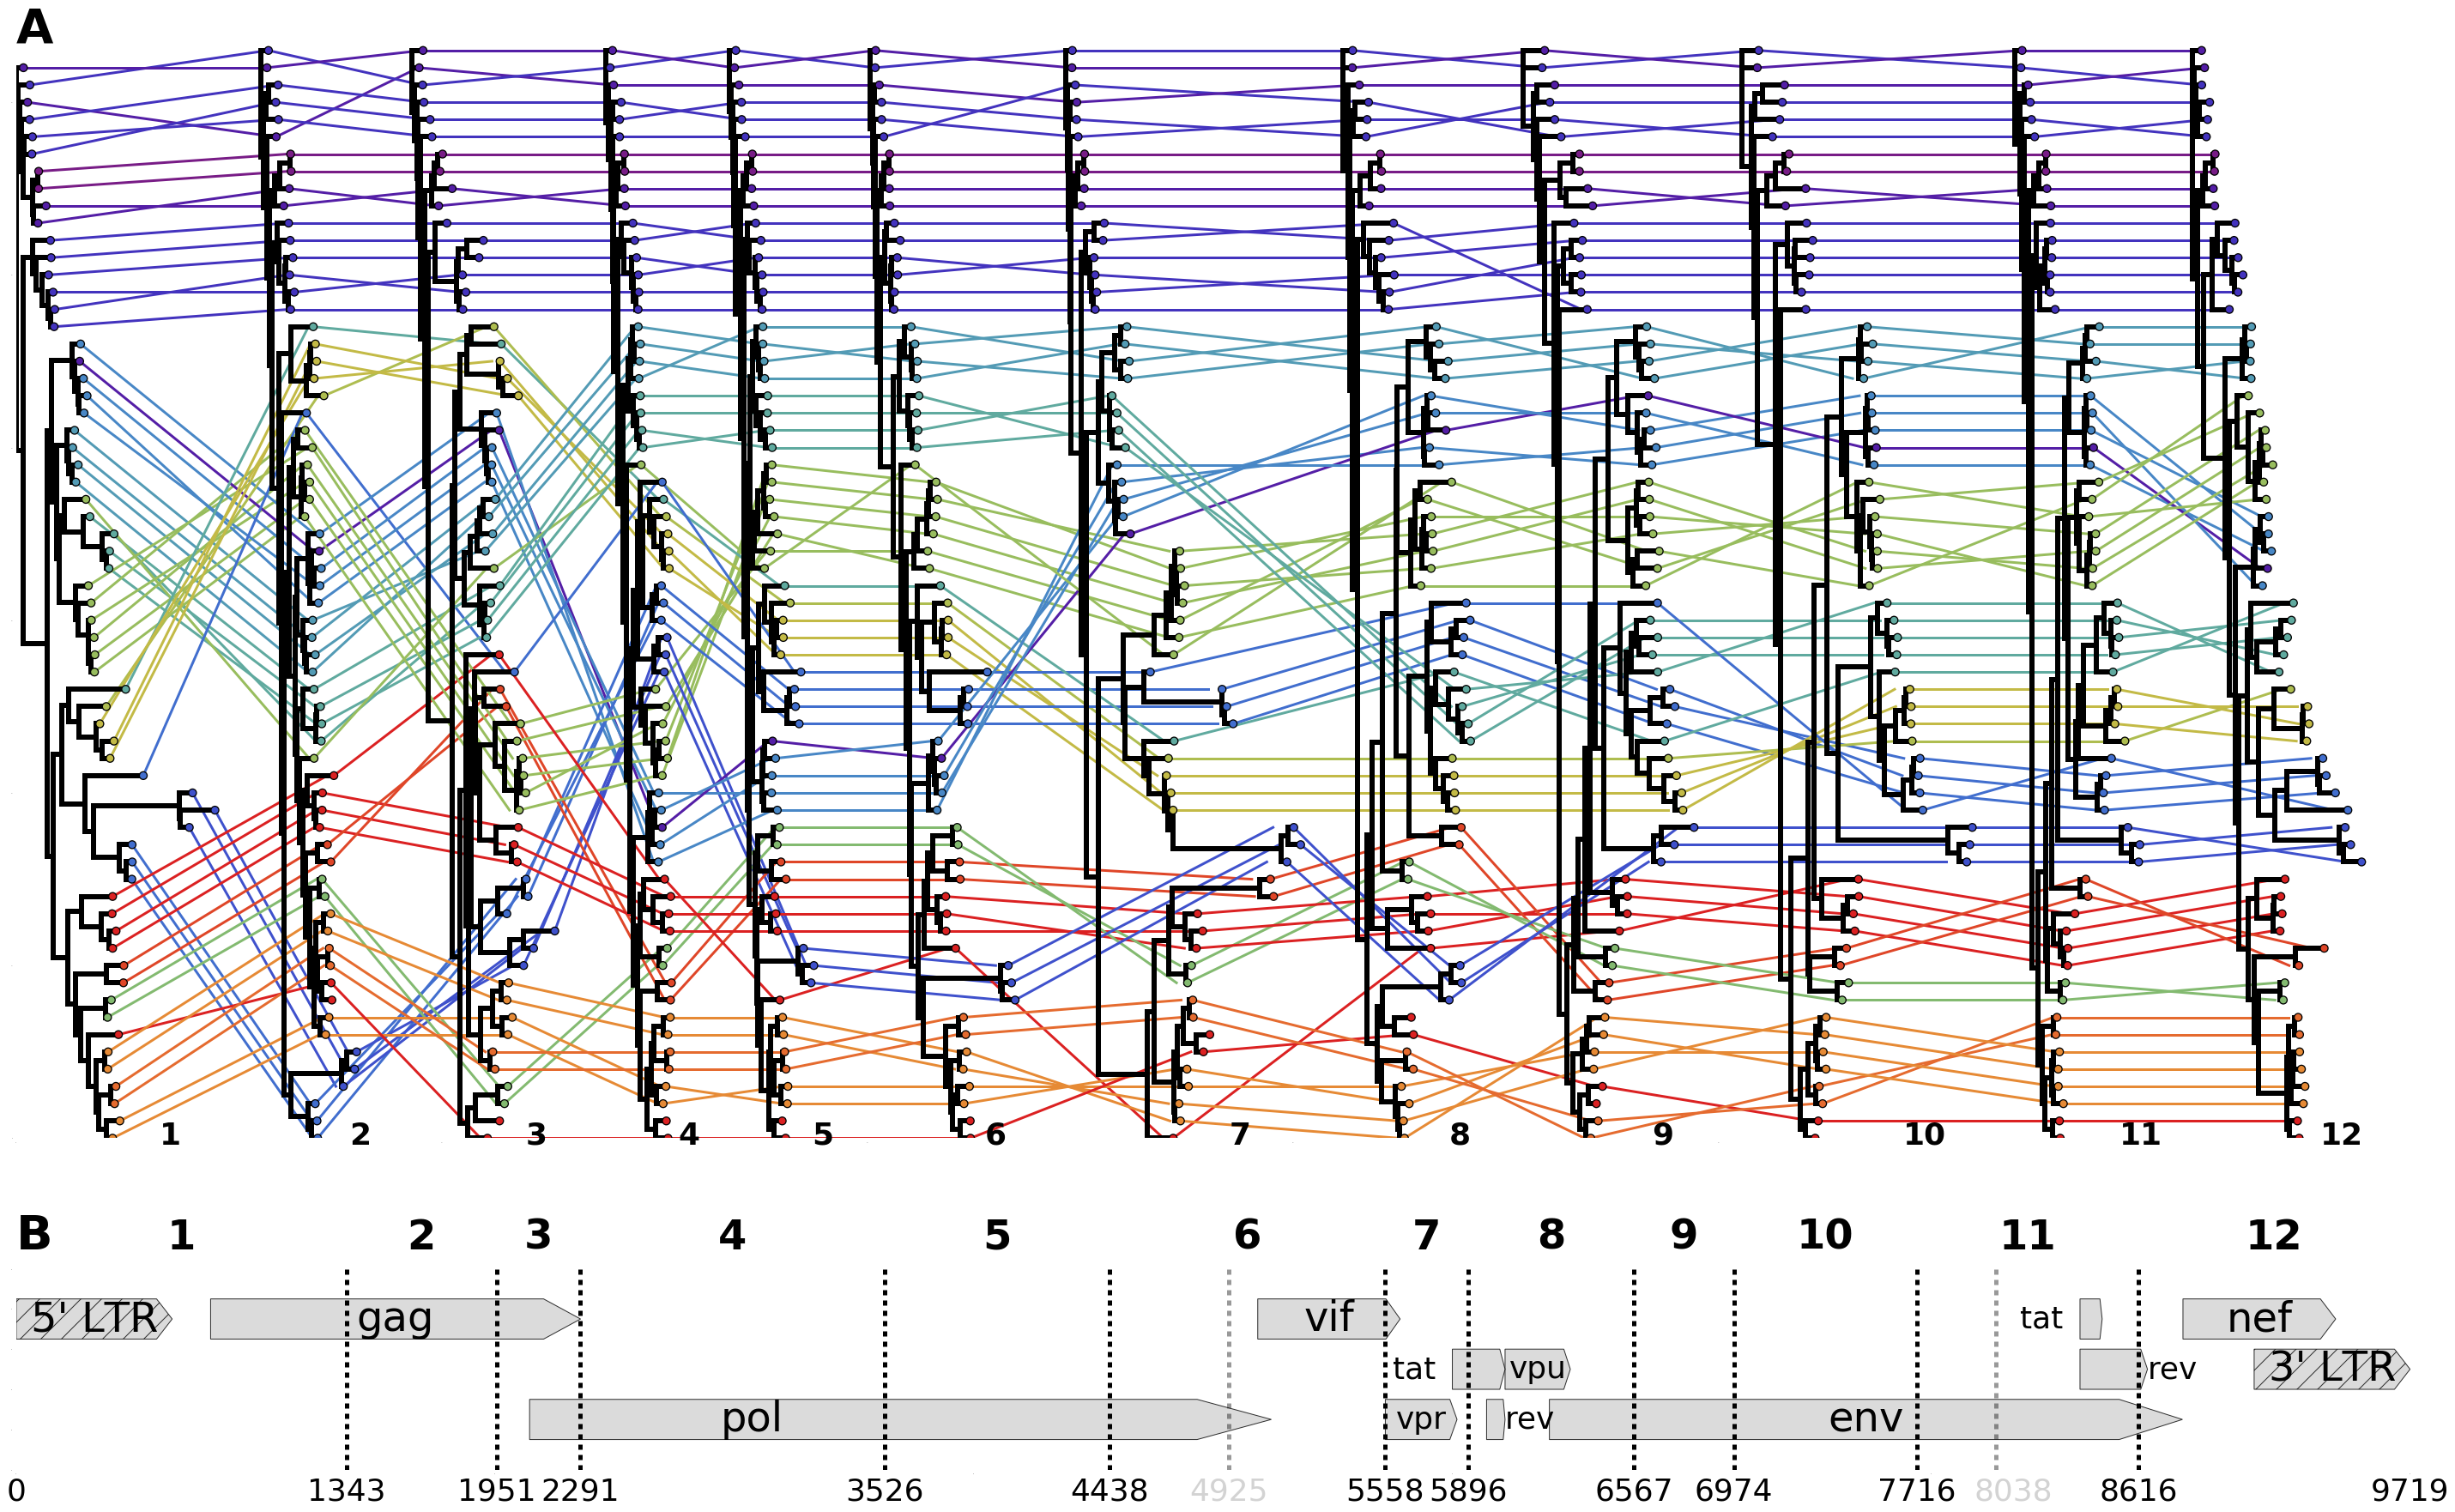

In [64]:
################
## Plot Genome Map
################

breakpoints = [1343.,1951.,2291.,3526.,4438.,5558.,5896.,6567.,6974.,7716.,8616.]

fig, (tr_ax, genome) = plt.subplots(2, figsize=(50,30), gridspec_kw = {'height_ratios':[5.5, 1.]}) #sharex=True)

genomeL=9719.0

def rescale(x):
    return (float(x)/genomeL)

for gene, i in CDS.items():
    length = rescale(i[1]-i[0])
    
    ## Label genes
    fs = 36 if gene in ['rev_1', 'rev_2', 'tat_1', 'tat_2', 'vpr', 'vpu'] else 48
    
    if gene.startswith('rev'):
        genome.text(rescale(i[0])+length, 0.25*i[2],'rev',va='center',ha='left',size=fs,zorder=11)
    elif gene.startswith('tat'):
        genome.text(rescale(i[0])-.025, 0.25*i[2],'tat',va='center',ha='left',size=fs,zorder=11)
    elif gene == 'pol':
        genome.text(rescale(i[0])+0.3*length, 0.25*i[2],'%s'%(gene),va='center',ha='center',size=fs,zorder=11)
    else:
        genome.text(rescale(i[0])+0.5*length, 0.25*i[2],'%s'%(gene),va='center',ha='center',size=fs,zorder=11)

    ## Draw Arrows
    c = 'lightgray'
    if 'LTR' in gene:
        genome.arrow(rescale(i[0]), .25*i[2], length, 0.0, hatch='/', alpha=0.8,head_width=0.20, width=0.20,head_length=0.1*rescale(i[1]-i[0]),length_includes_head=True,facecolor=c)
    else:
        genome.arrow(rescale(i[0]), .25*i[2], length, 0.0, alpha=0.8,head_width=0.20, width=0.20,head_length=0.1*rescale(i[1]-i[0]),length_includes_head=True,facecolor=c)

## Add breakpoint lines        
plt.eventplot([rescale(bp) for bp in breakpoints], orientation='horizontal', lineoffsets=0.5,
          linelengths=1, linewidths=5, linestyles='--', color='k')

excluded_breakpoints = [4925., 8038.]
plt.eventplot([rescale(bp) for bp in excluded_breakpoints], orientation='horizontal', lineoffsets=0.5,
          linelengths=1, linewidths=5, linestyles='--', color='k', alpha=0.4)



## Label breakpoint coordinates
for bp in breakpoints:
    genome.text(rescale(bp), -0.15, '%d'%int(bp), size=36, ha='center')
genome.text(0, -0.15, '0', size=36, ha='center')
genome.text(1, -0.15, '9719', size=36, ha='center')
genome.text(rescale(4925.), -0.15, '4925', size=36, ha='center', color='lightgray')
genome.text(rescale(7950.), -0.15, '8038',size=36, ha='left', color='lightgray')


## Label segment numbers
breakpoints = [0.]+breakpoints+[genomeL] # Add endpoints
for n, bp in enumerate(breakpoints[:-1]):
    x = (breakpoints[n] + breakpoints[n+1]) / 2. # Center text in each segment
    genome.text(rescale(x), 1.1, '%d'%(n+1), size=48, fontweight='bold', ha='center')

genome.set_ylim(0,1) ## Format axes
genome.set_xlim(0, 1)

genome.spines['top'].set_visible(False)
genome.spines['right'].set_visible(False)
genome.spines['left'].set_visible(False)
genome.spines['bottom'].set_visible(False)

genome.tick_params(axis='x',labelsize=0,size=0)
genome.tick_params(axis='y',labelsize=0,size=0)

######################
## Plot Trees
#####################

cumulative_displace=0 ## this tracks the "current" x position, so trees are plotted one after another

branchWidth=6 ## increase branch width, since trees will be smaller

tree_names=range(ntrees) ## define order in which dict will be accessed

tip_positions={x:{} for x in tree_names} ## remember the position of each tip in each tree

traitName = 'host'

for tr in tree_names: ## iterate over trees
    cur_tree=trees[tr] ## fetch tree object
    for k in cur_tree.Objects: ## iterate over branches
        if isinstance(k,bt.leaf): ## only interested in leaves
            k.name = k.numName
            k.traits['host'] = k.name.split('x')[1].upper()
            if k.traits['host'].startswith('H'):
                k.traits['host'] = 'HIV'
            elif k.traits['host'].startswith('MND'):
                k.traits['host'] = 'MND'
            elif k.traits['host'].startswith('MUS'):
                k.traits['host'] = 'MUS'
            tip_positions[tr][k.name]=(k.height,k.y) ## remember tree, tip's position

frac_pos = 0.0
maxy = 0.0
# cmap = mpl.cm.viridis
for t,tr in enumerate(tree_names): ## iterate over trees
    cur_tree=trees[tr] ## fetch tree object
    
    for k in cur_tree.Objects: ## iterate over branches
    #     x=k.x ## or from x position determined earlier
        x=k.height*1.1 ## or use absolute time instead
        y=k.y ## get y position from .drawTree that was run earlier, but could be anything else
        if y > maxy:
            maxy = y
        
    #     xp=k.parent.x ## get x position of current object's parent
        xp=k.parent.height*1.1 ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x
    
        x+=cumulative_displace ## adjust branch position by displacement, which depends on the position of tree in the overall plot
        xp+=cumulative_displace ## same for branch's parent

        if k.traits.has_key(traitName):
            c=colors[k.traits[traitName]] ## can be discrete too
        else:
            c='k'
            
        if k.branchType=='leaf': ## if leaf...
            s=60 ## tip size can be fixed

            tr_ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
            tr_ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath

            if t+1<len(tree_names) and k.name in tip_positions[0] and k.name in tip_positions[tree_names[t+1]]:
                pos_in_first_tree=tip_positions[0][k.name][1] ## fetch y coordinate of same tip in the first tree
                frac_pos=pos_in_first_tree/float(len(cur_tree.Objects))*2.0 ## normalize coordinate to be within interval [0.0,1.0]

                if t!=len(tree_names)-1: ## as long as we're not at the last tree - connect tips with coloured lines
                    next_x,next_y=tip_positions[tree_names[t+1]][k.name] ## fetch coordinates of same tip in next tree
                    next_x+=cumulative_displace+cur_tree.treeHeight+1.5 ## adjust x coordinate by current displacement and future displacement

                    tr_ax.plot([x,next_x],[y,next_y],lw=3,ls='-',color=c,zorder=0) ## connect current tip with same tip in the next tree
            else:
                pass
            
        elif isinstance(k,bt.node): ## if node...
            tr_ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color='k',ls='-',zorder=9) ## plot vertical bar

        tr_ax.plot([xp,x],[y,y],lw=branchWidth,color='k',ls='-',zorder=9) ## always plot branch

    tr_ax.text(cumulative_displace+((cur_tree.treeHeight+1.5)/1.7), -0.35, '%d'%(t+1), fontsize=36, fontweight='bold')
    cumulative_displace+=cur_tree.treeHeight+1.5 ## increment displacement by the height of the tree

tr_ax.set_ylim(0.0,maxy+1.0) ## set y limits
tr_ax.set_xlim(0.0,cumulative_displace)

tr_ax.spines['top'].set_visible(False)
tr_ax.spines['right'].set_visible(False)
tr_ax.spines['left'].set_visible(False)
tr_ax.spines['bottom'].set_visible(False)

tr_ax.tick_params(axis='x',labelsize=0,size=0)
tr_ax.tick_params(axis='y',labelsize=0,size=0)    
 
tr_ax.text(0.0, maxy+0.5, 'A', size=56, fontweight='bold')
genome.text(0.0, 1.1, 'B', size=56, fontweight='bold')
    
plt.show()



### Figure 1: There have been at least 13 interlineage recombination events among SIVs.  

The SIV LANL compendium, slightly modified to reduce overrepresentation of HIV, was analyzed with GARD to identify the 13 recombination breakpoints across the genome (dashed lines in B; numbering according to the accepted HXB2 reference genome--accession K03455, illustrated). Two of these breakpoints were omitted from further analyses because they created extremely short fragments (< 500 bases; gray dashes in **B**). For each of the 11 remaining breakpoints used in further analyses, we split the compendium alignment along these breakpoints and built a maximum likelihood tree, displayed in **(A)**. Each viral sequence is color-coded by host species, and its phylogenetic position is traced between trees. Heuristically, straight, horizontal colored lines indicate congruent topological positions between trees (likely not a recombinant sequence); criss-crossing colored lines indicate incongruent topological positions between trees (likely a recombinant sequence).